# Random Bayesian Network generation, no tears

In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.dag import is_directed_acyclic_graph
from networkx.algorithms.shortest_paths.generic import shortest_path


np.random.seed(37)

def get_simple_ordered_tree(n):
    g = nx.DiGraph()
    
    for i in range(n):
        g.add_node(i)
    
    for i in range(n - 1):
        g.add_edges_from([(i, i+1, {})])
    return g

def convert_to_undirected_graph(g):
    u = nx.Graph()
    for n in g.nodes:
        u.add_node(n)
    for e in g.edges:
        u.add_edges_from([(e[0], e[1], {})])
    return u

def is_connected(g):
    u = convert_to_undirected_graph(g)
    return nx.is_connected(u)

def get_random_node_pair(n):
    i = np.random.randint(0, n)
    j = i
    while j == i:
        j = np.random.randint(0, n)
    return i, j

def edge_exists(i, j, g):
    return j in list(g.successors(i))

def del_edge(i, j, g):
    if g.has_edge(i, j) is True:
        g.remove_edge(i, j)

        if is_connected(g) is False:
            g.add_edges_from([(i, j, {})])
        
def add_edge(i, j, g):
    g.add_edges_from([(i, j, {})])
    if is_directed_acyclic_graph(g) is False:
        g.remove_edge(i, j)
        
def find_predecessor(i, j, g):
    parents = list(g.predecessors(j))
    u = convert_to_undirected_graph(g)
    for pa in parents:
        try:
            path = shortest_path(u, pa, i)
            return pa
        except:
            pass
    return None
        
def generate_multi_connected_structure(n, max_iter=10):
    g = get_simple_ordered_tree(n)
    for it in range(max_iter):
        i, j = get_random_node_pair(n)
        if g.has_edge(i, j) is True:
            del_edge(i, j, g)
        else:
            add_edge(i, j, g)
    return g
    
def generate_singly_structure(n, max_iter=10):
    g = get_simple_ordered_tree(n)
    
    counter = 0
    for it in range(max_iter):
        i, j = get_random_node_pair(n)
        if g.has_edge(i, j) is True or g.has_edge(j, i) is True:
            pass
        else:
            p = np.random.random()
            k = find_predecessor(i, j, g)
            if k is not None:
                g.remove_edge(k, j)
                if p < 0.5:
                    g.add_edges_from([(j, i, {})])
                else:
                    g.add_edges_from([(i, j, {})])
                
                if is_connected(g) is False:
                    g.add_edges_from([(k, j, {})])
                
                    if p < 0.5:
                        g.remove_edge(j, i)
                    else:
                        g.remove_edge(i, j)
    return g

True


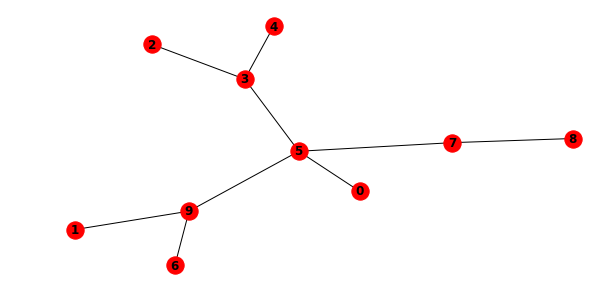

In [37]:
u = generate_singly_structure(10, 1000)
plt.figure(figsize=(10, 5))
plt.subplot(111)
nx.draw(convert_to_undirected_graph(u), with_labels=True, font_weight='bold')
print(is_connected(u))

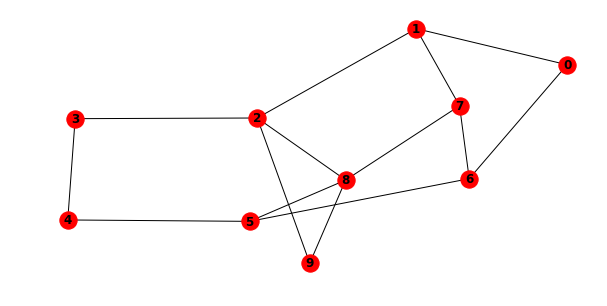

In [51]:
g = generate_multi_connected_structure(10, 10)
plt.figure(figsize=(10, 5))
plt.subplot(111)
nx.draw(convert_to_undirected_graph(g), with_labels=True, font_weight='bold')

# References

* [Random generation of Bayesian Networks](https://pdfs.semanticscholar.org/5273/2fb57129443592024b0e7e46c2a1ec36639c.pdf)

# Take a Look!

Take a look at [Dr. Amos Tversky](https://en.wikipedia.org/wiki/Amos_Tversky)!